# Data processing

This code is made to be run locally within current repository. If you work in Google Colab, adjust the path to the `raw_data.csv` file accordingly and install the libraries provided in the requirements.

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import rdkit
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

from collections import defaultdict
from tqdm.notebook import tqdm

In [ ]:
# Reading data
df = pd.read_csv('/content/drive/MyDrive/статья/raw_data.csv')

In [ ]:
df

,ID,Smiles,IC50,Standard Units
0,CHEMBL3698392,Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc([C@@]3(O)C...,2.750,nM
1,CHEMBL3917084,Cc1ncc(-c2cn3ccnc3c(Nc3ccc(N4CCN(C5COC5)CC4)cc...,6.200,nM
2,CHEMBL3986824,Nc1cncc(-c2cn3ccnc3c(Nc3ccc(N4CCN(C5COC5)CC4)c...,13.500,nM
3,CHEMBL30548,CN(C)c1ccc(-c2cc3ncccc3c(N(C)CCCN)n2)cc1,72.000,nM
4,CHEMBL514190,c1ccc(COc2cccc(Nc3nccc(-c4nccs4)n3)c2)cc1,500.000,nM
...,...,...,...,...
3508,24,NCCCNc3nc(c2ccc(N1CCOCC1)cc2)cc4ncccc34,8.097,pIC50
3509,25,CN(C)CCN(C)c3ccc(c2cc1ncccc1c(NCCCN)n2)cc3,7.149,pIC50
3510,26,CN(C)CCCN(C)c3ccc(c2cc1ncccc1c(NCCCN)n2)cc3,6.377,pIC50
3511,27,NCCCNc2nc(c1ccc(Br)cc1)cc3ncccc23,6.585,pIC50


## Converting $\mbox{IC}_{50}$ to one unit of measurement

For further work on building a predictive model, we need to convert our data to one unit of measurement.

We chose **nM** - **nanomolar concentration** as the standard unit of measurement, since this unit is the most common.




In [ ]:
df['Standard Units'].value_counts()

,count
Standard Units,
nM,3485
pIC50,28


In [ ]:
# Converting pIC50=-logIC50(μM) to nM
df.loc[df['Standard Units'] == 'pIC50', 'IC50'] = df['IC50'].apply(lambda x: (10 ** (-x)) * (10**(9)))

In [ ]:
df = df.drop('Standard Units', axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513 entries, 0 to 3512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3513 non-null   object 
 1   Smiles  3513 non-null   object 
 2   IC50    3513 non-null   float64
dtypes: float64(1), object(2)
memory usage: 82.5+ KB


In [ ]:
# Delete values that are equal to 0
df = df.loc[df['IC50'] > 0]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3510 entries, 0 to 3512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3510 non-null   object 
 1   Smiles  3510 non-null   object 
 2   IC50    3510 non-null   float64
dtypes: float64(1), object(2)
memory usage: 109.7+ KB


## Duplicate removing

In the resulting database, different $IC_{50}$ values exist for the same molecule represented as SMILES.

To handle duplicates, $2$ basic rules were established:

1. If all $IC_{50}$ values for the same SMILES are within $10\%$ of their median value, then combine them by averaging the $IC_{50}$ values.

2. If the difference between the $IC_{50}$ values is greater than $10\%$ of their median, then take the lowest $IC_{50}$ value to avoid missing a potentially effective drug.

In [ ]:
def replace_smiles(df: pd.DataFrame, smiles: str, new_value: float) -> pd.DataFrame:
    df = df.drop(index=[row for row in df.index if smiles == df.loc[row, 'Smiles']])
    new_dict = {'ID':['Filtered'],
                'Smiles':[smiles],
                'IC50':[new_value]
                }
    df = pd.concat([df, pd.DataFrame(new_dict) ], ignore_index = True)
    return df

In [ ]:
# Gather duplicates
duplicates = defaultdict(list)
for smiles, value in zip(df['Smiles'], df['IC50']):
    duplicates[smiles].append(value)

smiles_drop_list = []

actions_done = {"exact": 0,
                "median": 0,
                "min": 0}

for smiles, values in tqdm(duplicates.items(), desc="Filtering duplicates"):
    # Remove after debugging is finished
    if len(values) == 0:
        raise f"ERROR: SMILES {smiles} have no IC50 data"

    if len(values) < 2: # Nothing to filter here
        continue

    # Merge SMILES if it has the same values
    if np.all(values == values[0]):
        actions_done["exact"] += len(values)
        df = replace_smiles(df, smiles, values[0])
        smiles_drop_list.append(smiles)
        print(f"Dropped same values: {smiles}")
        continue

    # If all the IC50 for the same SMILES are withing the 10% range of their median value, then merge them by averaging the IC50 value
    if (np.max(values) - np.min(values)) <= 0.1 * np.median(values):
        smiles_drop_list.append(smiles)
        df = replace_smiles(df, smiles, np.mean(values))
        actions_done["median"] += (len(values) - 1)
        continue
    # If the difference among IC50 values is larger than 10%, then grab the lowest IC50 value so we do not skip a potential effective drug.
    else:
        smiles_drop_list.append(smiles)
        df = replace_smiles(df, smiles, np.min(values))
        actions_done["min"] += (len(values) - 1)

total_changes = sum(list(actions_done.values()))
print(f"Totally {total_changes} records were affected")
print(f"{actions_done['exact']} of the same records were merged")
print(f"{actions_done['median']} of the records were replaced via their average value")
print(f"{actions_done['min']} of the records were replaced via their minimum values")
print("------------------")
print("All affected SMILES:")
for i, smiles in enumerate(smiles_drop_list):
    print(i, smiles)

Filtering duplicates:   0%|          | 0/3199 [00:00<?, ?it/s]

Totally 311 records were affected
0 of the same records were merged
69 of the records were replaced via their average value
242 of the records were replaced via their minimum values
------------------
All affected SMILES:
0 Nc1cncc(-c2cn3ccnc3c(Nc3ccc(N4CCN(C5COC5)CC4)cc3)n2)n1
1 CN(C)c1ccc(-c2cc3ncccc3c(N(C)CCCN)n2)cc1
2 NCCCNc1nc(-c2ccc(Cl)cc2)cc2ncccc12
3 CNc1nc(-c2ccc(OC)cc2)nc2ccccc12
4 Cc1cc(C)cc(Nc2nccc(-c3nc(C)c(C(=O)N[C@H](C)CO)s3)n2)c1
5 COc1cc(/C=C/[N+](=O)[O-])ccc1OC(=O)c1ccccc1
6 Cc1ccc(-c2cc3ncccc3c(NCCCN)n2)cc1
7 Cc1cc(Nc2nccc(-c3nccs3)n2)cc(C(F)(F)F)c1
8 COc1ccc2c(c1)c(/C=C1\C(=O)Nc3ccc(S(=O)(=O)NCC(C)C)cc31)cn2C
9 CN(C)c1ccc(-c2cc3ncccc3c(NCCCN)n2)cc1
10 CC(C)(CO)NC(=O)c1c[nH]c2ncc(-c3nn(CCC(O)CO)c4cc(F)ccc34)nc12
11 CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4
12 COc1ccc2c(c1)c(/C=C1\C(=O)Nc3ccc(S(=O)(=O)NCCC(N)=O)cc31)cn2C
13 Cn1nc(-c2cnc3[nH]cc(C(=O)NC4COCC(N)C4)c3n2)c2ccc(F)cc21
14 CC1(C)OCC(=O)Nc2cc(Nc3nc(NCC(F)(F)F)c4occc4n3)ccc2

After removing duplicates, the dataset contains $3199$ molecules

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3199 non-null   object 
 1   Smiles  3199 non-null   object 
 2   IC50    3199 non-null   float64
dtypes: float64(1), object(2)
memory usage: 75.1+ KB


## Distribution of IC50 values. Removing outliers

Machine learning models work best with data that is normally distributed. Let's check what distribution we have:

<ipython-input-36-a3a55377a202>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df['IC50']), hist=True, kde=False,


Text(0, 0.5, 'Frequency')

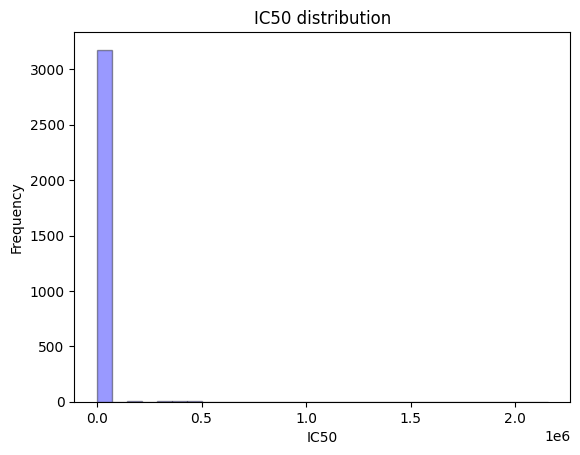

In [ ]:
sns.distplot((df['IC50']), hist=True, kde=False,
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('IC50 distribution')
plt.xlabel('IC50')
plt.ylabel('Frequency')

We see that such a distribution does not suit us. Let's try to convert our data into pIC50 *(similar transformation is often applied to chemical data)*.

<ipython-input-37-02c6c663552f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(-np.log10(df['IC50']*(10**(-9))), hist=True, kde=False,


Text(0, 0.5, 'Частота')

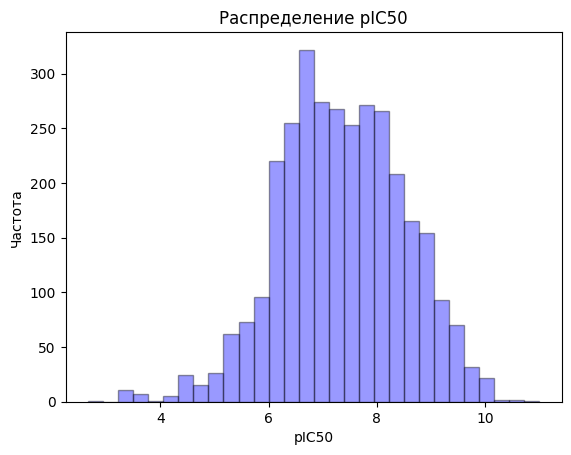

In [ ]:
sns.distplot(-np.log10(df['IC50']*(10**(-9))), hist=True, kde=False,
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('pIC50 distribution ')
plt.xlabel('pIC50')
plt.ylabel('Frequency')

The situation is much better now. Let's convert all our values to $\mbox{pIC}_{50}$.

In [ ]:
df['pIC50'] = -np.log10(df['IC50']*(10**(-9)))

### Removing outliers

Outliers are removed using the interquartile range (IQR) method.**

**Main steps:**

1. The first $(Q1)$ and third $(Q3)$ quartiles of the 'lgIC50' column are calculated.

2. The interquartile range $IQR$ is calculated as the difference between $Q3$ and $Q1.$

3. The filtering boundaries are determined: $Q1 - 1{.}5IQR$ and $Q3 + 1{.}5IQR$. Values ​​outside these boundaries are considered outliers.

4. The data is filtered by the calculated boundaries, resulting in a data set without outliers.

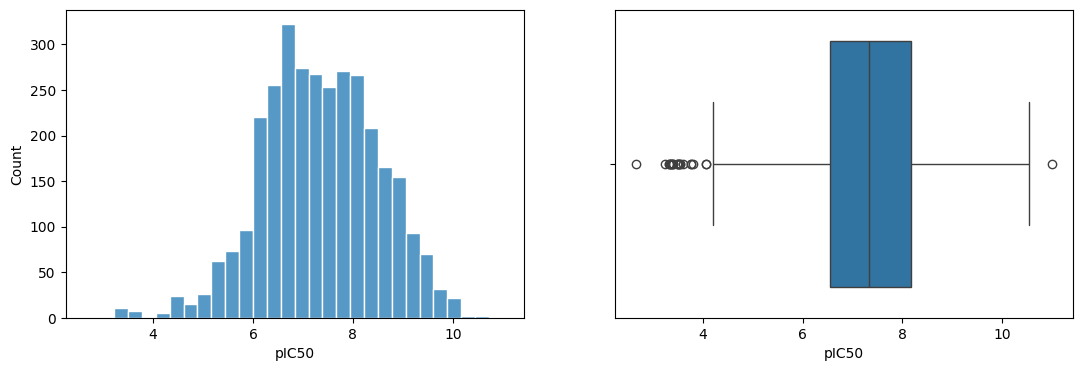

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 4))
sns.set_style('whitegrid')
sns.histplot(df['pIC50'], kde = False, bins = 30, ax=axs[0])
sns.boxplot(x=df['pIC50'], ax=axs[1])
plt.show()

In [ ]:
Q1 = df['pIC50'].quantile(0.25)
Q3 = df['pIC50'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
filter = (df['pIC50'] >= Q1 - 1.5 * IQR) & (df['pIC50'] <= Q3 + 1.5 *IQR)
final_dataset= df.loc[filter]

In [ ]:
columns = list(final_dataset.columns)
last_column = columns.pop()

columns.insert(3, last_column)

data = final_dataset[columns]

In [ ]:
data

,Smiles,IC50,pIC50
0,Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc([C@@]3(O)C...,2.750000,8.560667
1,Cc1ncc(-c2cn3ccnc3c(Nc3ccc(N4CCN(C5COC5)CC4)cc...,6.200000,8.207608
2,c1ccc(COc2cccc(Nc3nccc(-c4nccs4)n3)c2)cc1,500.000000,6.301030
3,c1cncc(Oc2cccc(Nc3nccc(-c4nccs4)n3)c2)c1,500.000000,6.301030
4,Cc1cc(Nc2nn(-c3ccc(C(F)(F)F)cc3)c(=O)c3ccccc23...,525.000000,6.279841
...,...,...,...
3171,CC(C)Cn1cnc(-c2ccnc(Nc3cc(Cl)c4[nH]c(C(=O)N(C)...,120.900000,6.917574
3172,CN1CCC(NC(=O)c2cc3cc(Nc4nccc(-c5cn(C)cn5)n4)cc...,5.700000,8.244125
3173,Cc1ccc(-c2cnc([C@@]3(O)CC[C@H](C(=O)O)C(C)(C)C...,0.900000,9.045757
3174,NCCCNc2nc(c1cccc(F)c1)cc3ncccc23,849.180475,6.071000


In [ ]:
data = data.drop(['ID'], axis=1)

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
data.to_csv('/content/drive/MyDrive/статья/Data/processed_df.csv', index = False)

In [ ]:
df = data.copy()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/статья/Data/processed_df.csv')

In [ ]:
df

,Smiles,IC50,pIC50
0,Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc([C@@]3(O)C...,2.750000,8.560667
1,Cc1ncc(-c2cn3ccnc3c(Nc3ccc(N4CCN(C5COC5)CC4)cc...,6.200000,8.207608
2,c1ccc(COc2cccc(Nc3nccc(-c4nccs4)n3)c2)cc1,500.000000,6.301030
3,c1cncc(Oc2cccc(Nc3nccc(-c4nccs4)n3)c2)c1,500.000000,6.301030
4,Cc1cc(Nc2nn(-c3ccc(C(F)(F)F)cc3)c(=O)c3ccccc23...,525.000000,6.279841
...,...,...,...
3171,CC(C)Cn1cnc(-c2ccnc(Nc3cc(Cl)c4[nH]c(C(=O)N(C)...,120.900000,6.917574
3172,CN1CCC(NC(=O)c2cc3cc(Nc4nccc(-c5cn(C)cn5)n4)cc...,5.700000,8.244125
3173,Cc1ccc(-c2cnc([C@@]3(O)CC[C@H](C(=O)O)C(C)(C)C...,0.900000,9.045757
3174,NCCCNc2nc(c1cccc(F)c1)cc3ncccc23,849.180475,6.071000


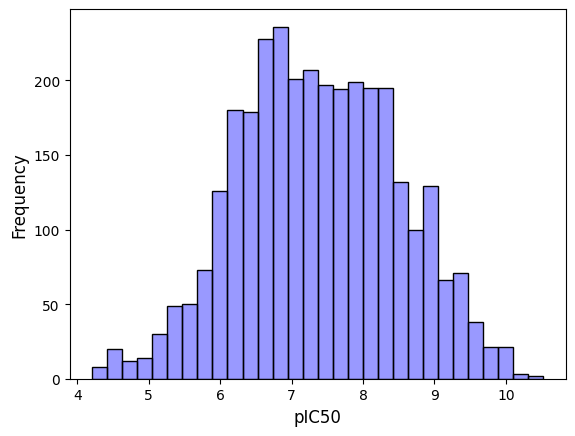

In [ ]:
sns.histplot(df['pIC50'], kde=False,
             bins=30, color = 'blue', alpha=0.4)

plt.xlabel('pIC50', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.savefig('Figure_A1.jpg', format='jpg', dpi=1000, bbox_inches='tight')
plt.savefig('Figure_A1.pdf', format='pdf', dpi=1000, bbox_inches='tight')

plt.show()

## Descriptors

**Morgan Fingerprints** were chosen as the main descriptors of molecules. We unload these descriptors using the `rdkit` library.

**Morgan fingerprints** are a type of descriptors that encode information about the structure of a molecule in the form of bit strings of a fixed length. They take into account the presence of different structural fragments in a molecule and their spatial arrangement.

Morgan fingerprints were chosen because they have proven themselves well in problems of modeling the properties of molecules based on their structure.

Two parameters are used to generate Morgan fingerprints:

* `radius` - the radius of the atom's neighborhood, within which neighboring atoms are taken into account

* `nBits` - the dimension of the resulting bit vector

The code selects these parameters in order to obtain the best quality of the model.

In [ ]:
# Function for obtaining fingerprint
def get_fingerprint_select(smiles, mfpgen):
    mol = Chem.MolFromSmiles(smiles)
    fp = mfpgen.GetFingerprintAsNumPy(mol)
    return fp

### Selected model for parameter fitting

The support vector machine regression (SVR)** method was chosen to build the $\mbox{IC}_{50}$ prediction model.

This machine learning algorithm is well suited for solving the regression problem and makes it possible to control the smoothness of the resulting model using the regularization parameter.

In addition, SVR is resistant to overfitting and is able to handle nonlinear dependencies, which is important when modeling the properties of molecules.

### Selection of parameters

In [ ]:
radius_values = [2, 3]
fpSize_values = [128, 256, 512, 1024, 2048]

metrics_data = []

df1 = df.copy()

for radius in radius_values:
    for fpSize in fpSize_values:
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)

        # Adding fingerprints for each molecule
        df['fingerprints'] = df.Smiles.apply(lambda x: get_fingerprint_select(x, mfpgen))

        new_fingerprints = np.vstack(df['fingerprints'].values)
        new_fingerprint_columns = [f'fingerprint_{i}_{radius}_{fpSize}' for i in range(new_fingerprints.shape[1])]
        new_fingerprint_df = pd.DataFrame(new_fingerprints, columns=new_fingerprint_columns)

        df = pd.concat([df, new_fingerprint_df], axis=1)

        df = df.drop('fingerprints', axis=1)

        # Splitting into train and test sets
        X = df.drop(['Smiles', 'pIC50'], axis=1)
        y = df['pIC50']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Training the SVR model
        model = SVR()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Metrics calculation
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Params (radius={radius}, fpSize={fpSize}): R2 = {r2}")

        metrics_data.append({'radius': radius, 'fpSize': fpSize, 'R2': r2})

        df = df1.copy()

# Creating a DataFrame with metrics
metrics_df = pd.DataFrame(metrics_data)

Params (radius=2, fpSize=128): R2 = 0.6627560759360235
Params (radius=2, fpSize=256): R2 = 0.6905555813544457
Params (radius=2, fpSize=512): R2 = 0.7030659984987635
Params (radius=2, fpSize=1024): R2 = 0.7188205257376341
Params (radius=2, fpSize=2048): R2 = 0.7280324190376095
Params (radius=3, fpSize=128): R2 = 0.6286705151560028
Params (radius=3, fpSize=256): R2 = 0.661778147947877
Params (radius=3, fpSize=512): R2 = 0.6836595246021075
Params (radius=3, fpSize=1024): R2 = 0.7047516060146912
Params (radius=3, fpSize=2048): R2 = 0.7124819690129833


The parameters that showed the best results: `radius=2, nBits=2048`.

In [ ]:
# Function for obtaining fingerprint
def get_fingerprint(smiles, radius = 2, fpSize = 2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    mol = Chem.MolFromSmiles(smiles)
    fp = mfpgen.GetFingerprintAsNumPy(mol)
    return fp

In [ ]:
df['fingerprints'] = df.Smiles.tolist()
df['fingerprints'] = df.fingerprints.apply(get_fingerprint)

In [ ]:
new_fingerprints = np.vstack(df['fingerprints'].values)
new_fingerprint_columns = [f'fingerprint_{i}' for i in range(new_fingerprints.shape[1])]
new_fingerprint_df = pd.DataFrame(new_fingerprints, columns=new_fingerprint_columns)

df = pd.concat([df, new_fingerprint_df], axis=1)

df = df.drop('fingerprints', axis=1)

In [ ]:
df

,Smiles,pIC50,fingerprint_0,fingerprint_1,fingerprint_2,fingerprint_3,fingerprint_4,fingerprint_5,fingerprint_6,fingerprint_7,...,fingerprint_2038,fingerprint_2039,fingerprint_2040,fingerprint_2041,fingerprint_2042,fingerprint_2043,fingerprint_2044,fingerprint_2045,fingerprint_2046,fingerprint_2047
0,Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc([C@@]3(O)C...,8.560667,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cc1ncc(-c2cn3ccnc3c(Nc3ccc(N4CCN(C5COC5)CC4)cc...,8.207608,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,c1ccc(COc2cccc(Nc3nccc(-c4nccs4)n3)c2)cc1,6.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,c1cncc(Oc2cccc(Nc3nccc(-c4nccs4)n3)c2)c1,6.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cc1cc(Nc2nn(-c3ccc(C(F)(F)F)cc3)c(=O)c3ccccc23...,6.279841,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,CC(C)Cn1cnc(-c2ccnc(Nc3cc(Cl)c4[nH]c(C(=O)N(C)...,6.917574,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3172,CN1CCC(NC(=O)c2cc3cc(Nc4nccc(-c5cn(C)cn5)n4)cc...,8.244125,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3173,Cc1ccc(-c2cnc([C@@]3(O)CC[C@H](C(=O)O)C(C)(C)C...,9.045757,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3174,NCCCNc2nc(c1cccc(F)c1)cc3ncccc23,6.071000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.drop('IC50', axis = 1)

In [ ]:
df.to_csv('/content/drive/MyDrive/статья/Data/df_fp.csv', index=False)

# Distribution of pIC50 values ​​in the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/статья/Data/processed_df.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176 entries, 0 to 3175
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Smiles  3176 non-null   object 
 1   IC50    3176 non-null   float64
 2   pIC50   3176 non-null   float64
dtypes: float64(2), object(1)
memory usage: 74.6+ KB


In [ ]:
# Defining activity categories
df['Activity'] = pd.cut(df['IC50'],
                        bins=[0, 50, 500, float('inf')],
                        labels=['Highly potent', 'Moderately active', 'Lowly active'])

# Counting the number of connections in each category
activity_counts = df['Activity'].value_counts()

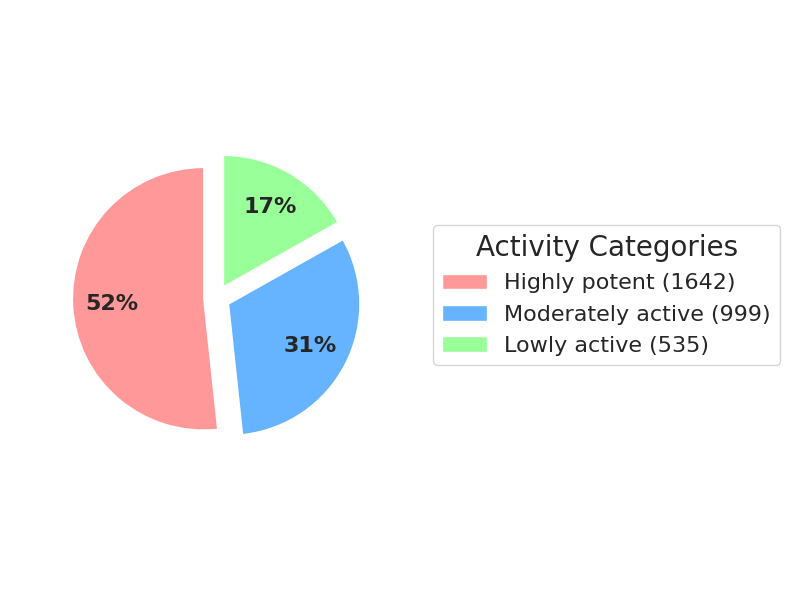

In [ ]:
# Creating a Pie Chart
fig, ax = plt.subplots(figsize=(8, 6))

explode = (0.1, 0.1, 0.1)

wedges, texts, autotexts = ax.pie(activity_counts.values,
                                  labels=None,
                                  autopct='%1.0f%%',
                                  pctdistance=0.7,
                                  colors=['#ff9999','#66b3ff','#99ff99'],
                                  startangle=90,
                                  explode=explode,)

plt.setp(autotexts, size=16, weight="bold")

ax.axis('equal')

legend = ax.legend(wedges, activity_counts.index,
                   title="Activity Categories",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1),
                   fontsize=16)

plt.setp(legend.get_title(), fontsize=20)

for i, (key, value) in enumerate(activity_counts.items()):
    legend.get_texts()[i].set_text(f'{key} ({value})')

plt.tight_layout()

plt.savefig('compound_activity_distribution.svg', format='svg', dpi=300, bbox_inches='tight')

plt.show()